In [1]:
#%% General Import Statements
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import eif as iso ## importing extended Isolation Forest

In [41]:
#%% Load dataset
df = pd.read_csv('.\input\creditcard.csv')
print(df.shape)
df.head(10)
# We have a large dataset (284807 rows, 31 columns - incl. target). 
# It contains a time offset column, an amount column and 28 encoded value columns.


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


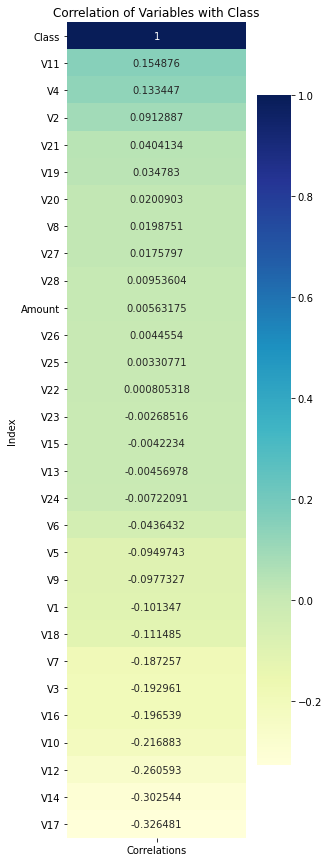

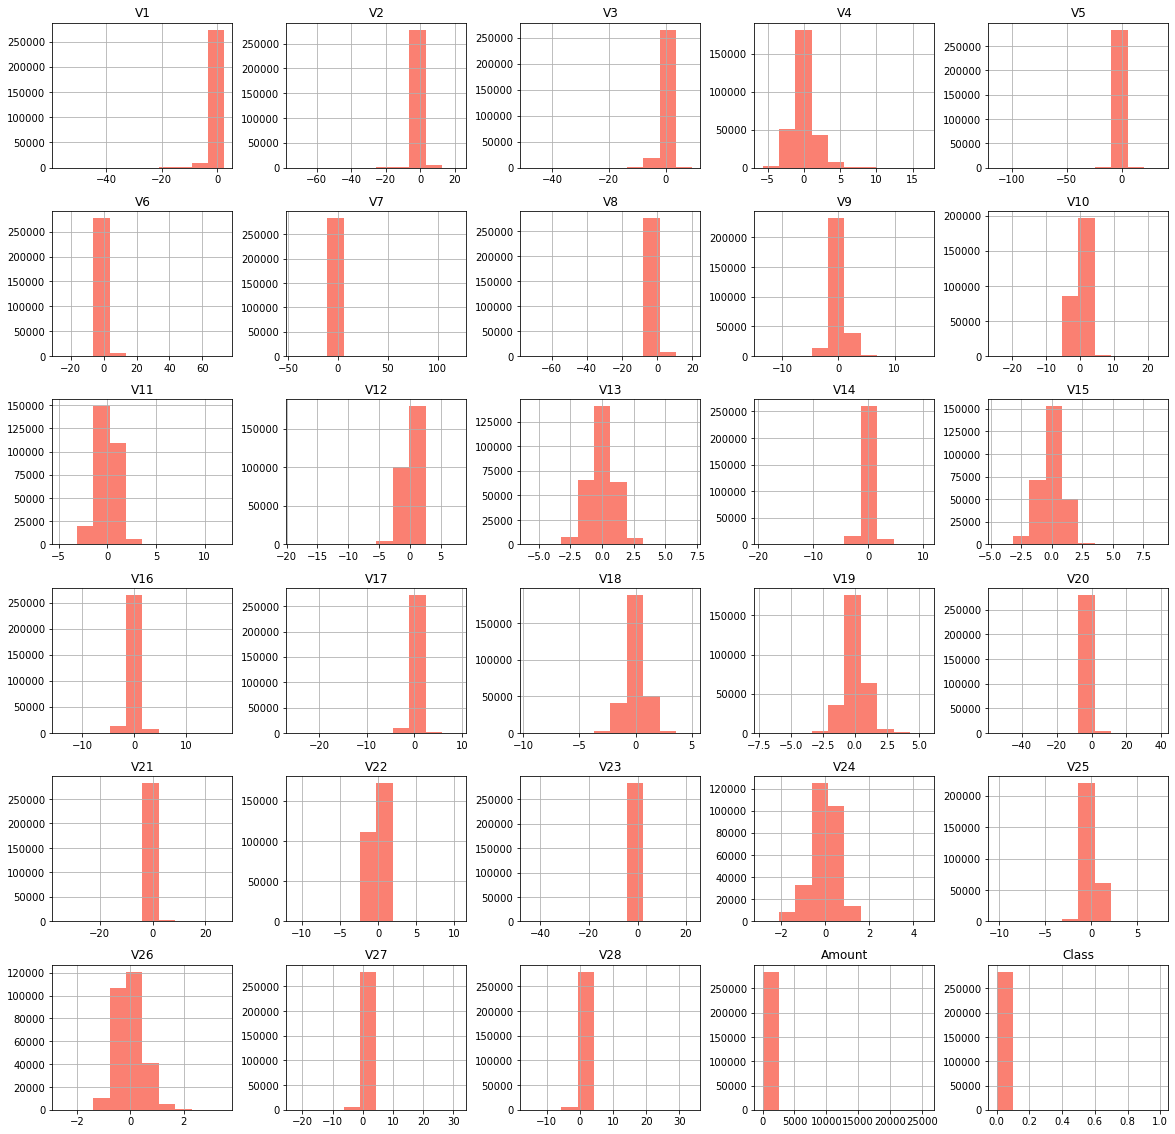

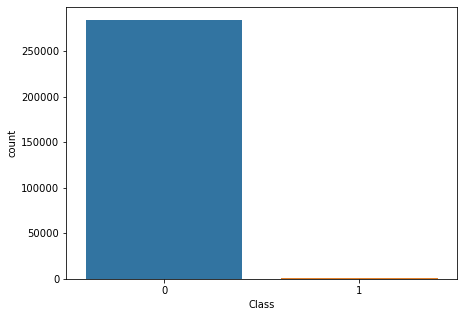

0    284315
1       492
Name: Class, dtype: int64

In [42]:
#%% EDA
# Check  datatypes for any discrepancies
df.dtypes

#  Description of all the columns
df.describe()

# Check for null values
df.isnull().sum()

# Drop Time axis
df = df.drop(['Time'] , axis=1)

# Correlation of different variables with the target variable
corr = df.corrwith(df['Class']).reset_index()
corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
plt.figure(figsize=(4,15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with Class")
plt.show()

df.hist(figsize=(20,20), color = "salmon")
plt.show()

# Distribution of Class
plt.figure(figsize=(7,5))
fig = sns.countplot(x="Class", data=df)
plt.show()

 # Prints total number of legit transactions
df[df['Class'] == 0]['Class'].count()

# Prints total number of fraudulent transactions
df[df['Class'] == 1]['Class'].count()

df["Class"].value_counts()
# A distribution of 284315 non-fraud and 492 fraud labels indicate a highly imbalanced data set.


In [23]:
inliers = df[df.Class==0] # Number of valid transactions
inliers = inliers.drop(['Class'], axis=1)  # X is input

In [24]:
outliers = df[df.Class==1] # Number of fraudulent transactions
outliers = outliers.drop(['Class'], axis=1)

In [43]:
# Compute outlier fraction
outlier_fraction = len(outliers)/float(len(inliers))
print("The outlier fraction is:",outlier_fraction)

# Organise input and output
X = df.drop('Class',axis = 1) # X is input
y = df['Class'] # y is output

a = LocalOutlierFactor(n_neighbors = 20,contamination = outlier_fraction)
y_prediction1 = a.fit_predict(X) # Fitting the model.
y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.
errors1 = (y_prediction1 != y).sum() # Total number of errors is calculated.
print(errors1)
print(accuracy_score(y_prediction1,y))
print(classification_report(y_prediction1,y))

# Isolation Forest
b = IsolationForest(max_samples = len(X),contamination = outlier_fraction).fit(X) # Fitting the model.
y_prediction2 = b.predict(X) # Prediction using trained model.
y_prediction2[y_prediction2 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction2[y_prediction2 == -1] = 1 # Fraudulent transactions are labelled as 1.
errors2 = (y_prediction2 != y).sum() # Total number of errors is calculated.
print(errors2)
print(accuracy_score(y_prediction2,y))
print(classification_report(y_prediction2,y))

The outlier fraction is: 0.0017304750013189597
985
0.9965415175891043
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284314
           1       0.00      0.00      0.00       493

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807

673
0.9976369962816926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284314
           1       0.32      0.32      0.32       493

    accuracy                           1.00    284807
   macro avg       0.66      0.66      0.66    284807
weighted avg       1.00      1.00      1.00    284807

